### Purpose of Notebook
The purpose of this notebook is to offer as a an example answer to the Guided Project for Linear Regression in Python course. Since the choice of model predictors is up to the student, results can differ. Use this solution as a guide to how to structure your own answer.

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [5]:
import os
os.getcwd()

     

'/drive/data'

In [6]:
# Load in the insurance dataset
insurance = pd.read_csv("/drive/data/insurance.csv")

In [7]:
insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Exploring The Dataset

In [8]:
# Columns in the dataset
insurance.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

The charges column is our outcome, while everything else are the potential predictors to use in the model

array([[<AxesSubplot:title={'center':'charges'}>]], dtype=object)

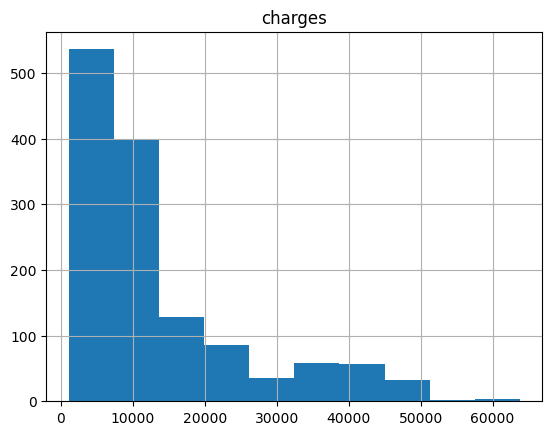

In [13]:
import matplotlib.pyplot as plt
insurance.hist("charges")

The charges column is highly skewed to the right. Extremely costly insurance charges are more common than extremely small ones. This makes it unlikely that the errors in the model will truly be centered at zero. It might be worth it to log-transform the outcome.

array([[<AxesSubplot:title={'center':'log_charges'}>]], dtype=object)

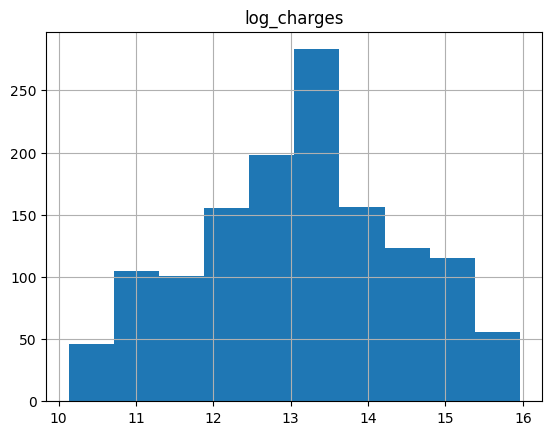

In [14]:

insurance["log_charges"] = np.log2(insurance["charges"])

insurance.hist("log_charges")

The log-transformed charges values are more centered, which is what we wanted. This makes it more likely that the errors will be unbiased.

In [15]:

# Checking the correlation between the continuous columns in the insurance data
insurance.corr()

<ipython-input-15-1ef058d635f0>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  insurance.corr()


,age,bmi,children,charges,log_charges
age,1.000000,0.109272,0.042469,0.299008,0.527834
bmi,0.109272,1.000000,0.012759,0.198341,0.132669
children,0.042469,0.012759,1.000000,0.067998,0.161336
charges,0.299008,0.198341,0.067998,1.000000,0.892964
log_charges,0.527834,0.132669,0.161336,0.892964,1.000000


Comments on correlation
age has 30% correlation with charges, bmi has 19.8% correlation, and number of children has 6.7% correlation.

<AxesSubplot:title={'center':'log_charges'}, xlabel='sex'>

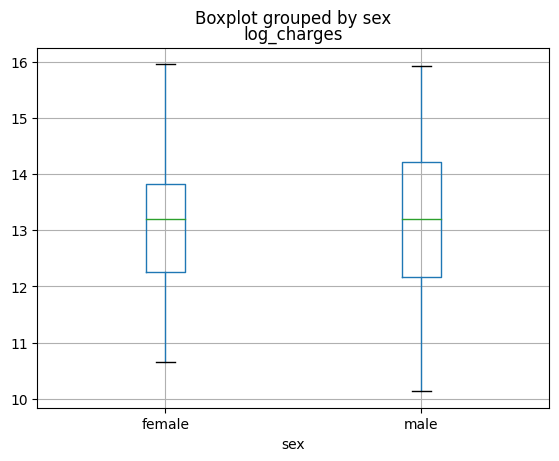

In [16]:

insurance.boxplot(column = ["log_charges"], by = "sex")

<AxesSubplot:title={'center':'log_charges'}, xlabel='smoker'>

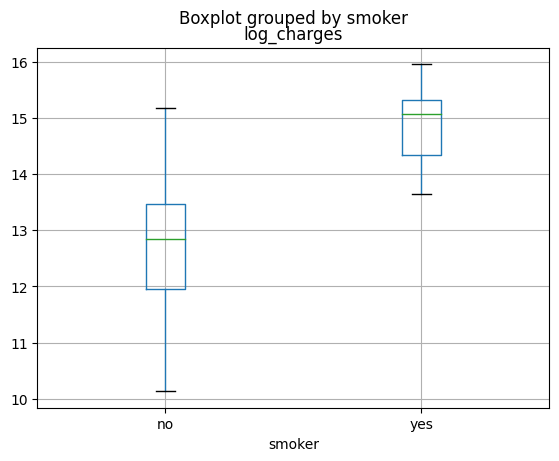

In [17]:

insurance.boxplot(column = ["log_charges"], by = "smoker")

<AxesSubplot:title={'center':'log_charges'}, xlabel='region'>

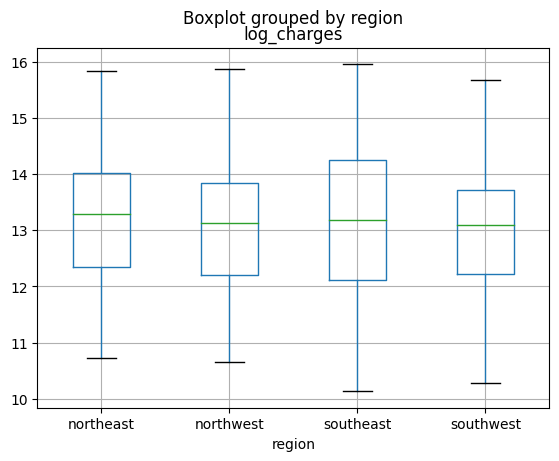

In [18]:

insurance.boxplot(column = ["log_charges"], by = "region")

Comments on plots
Males seem to have a wider distribution of charges compared to women. Smokers have much higher costs than non-smokers. There doesn't seem tobe many appreciable differences between regions.

Dividing The Data
Based on the univariate relationships shown above, age, bmi and smoker are positively associated with higher charges. We'll include these predictors in our final model.

In [19]:
# Splitting the data up into a training and test set
insurance["is_smoker"] = (insurance["smoker"] == "yes")
X = insurance[["age", "bmi", "is_smoker"]]
y = insurance["log_charges"]

# 75% for training set, 25% for test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, 
                                                    random_state = 1)

### Build The Model

In [20]:

# Training and checking model performance on training set
insurance_model = LinearRegression()
insurance_model.fit(X_train, y_train)

LinearRegression()

In [21]:
# Get predicted values by model
y_pred = insurance_model.predict(X_train)

# MSE on the log scale for the insurance charges
mean_squared_error(y_train, y_pred)
     

0.45466653392706446

In [22]:
# MSE on the original scale for the insurance charges
np.exp(mean_squared_error(y_train, y_pred))

1.5756478703108872

In [23]:

# Coefficient of determination
r2_score(y_train, y_pred)

0.7421118855283421

Comments
The training MSE for the model is 0.454 and is 1.57 on the original scale. The 
 indicates that the model can explain 74% of the variation in the log-insurance charges. These preliminary results are promising, but we must remember that these are optimistic values.

## Residual Diagnostics

<AxesSubplot:xlabel='fitted', ylabel='residuals'>

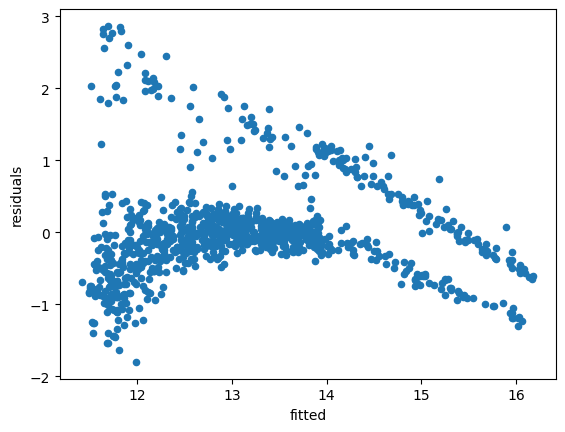

In [24]:
# Quick visual check of residuals
check = pd.DataFrame()
check["residuals"] = y_train - y_pred
check["fitted"] = y_pred

check.plot.scatter(x = "fitted", y = "residuals")

The residuals suggest some violations to the assumptions of linear regression. As fitted values get larger, the residuals trend downward. We expect an even band, centered around zero. This does not necessarily make the model predictions unusable, but it puts into question the linear regression assumptions.

In [25]:
## Interpreting The Model

In [26]:

# Getting the non-intercept coefficients
insurance_model.coef_
     

array([0.04892865, 0.01523672, 2.23063344])

A year increase in the subject is associated with a 0.04 increase in the log charges, holding smoking status and bmi constant. About a 4% increase in the charges on the regular scale.
A unit increase in the subject BMI is associated with a 0.01 increase in the log charges, holding smoking status and age constant. About a 1.5% increase in the charges on the regular scale.
A smoker is associated with a 2.23 increase in the log charges, holding age and bmi constant. About a 930% increase in the charges on the regular scale.
Note: we are not concerned about if these changes are statistically significant, so we don't know if these associations are truly non-zero. Our primary goal is prediction.

### Final Model Evaluation

In [27]:

# Getting MSE on test model
test_pred = insurance_model.predict(X_test)

mean_squared_error(y_test, test_pred)

0.4355350875308208

In [28]:

# Putting the outcome (in log-terms) back into the original scale
np.exp(mean_squared_error(y_test, test_pred))

1.5457899706350975

### Drawing Conclusions
The test MSE was about 0.435, while the training MSE was about 0.454. In this case, the two errors match up pretty well, so we can conclude that the model is not overfit. The residuals suggest that the model is predicting much lower costs for subjects who were actually charged much higher. Therefore the model struggles with these higher costs. As a whole, the model predictions are too conservative.

We might improve the model by including more complex terms in the regression, such as interactions or quadratic terms.